# LLaVA 1.6 Mistral Test (7B params)

Highly capable VLM based on Mistral architecture with excellent performance.

**Model:** `llava-hf/llava-v1.6-mistral-7b-hf`  
**Size:** 7B parameters  
**License:** Permissive  
**Features:** Highly capable, excellent accuracy  
**Requirements:** ~14GB disk, ~8GB RAM/VRAM


In [ ]:
import sys
sys.path.append('..')

import torch
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
from PIL import Image
from vlm_utils import get_device_info, load_test_images, display_image, print_section, print_subsection

device = get_device_info()


Using device: mps
PyTorch version: 2.9.1
Using Apple Silicon MPS (Metal Performance Shaders)


## Load Test Images


In [2]:
image_files = load_test_images()


Found 1 image(s) to test:
  - sample_image.jpg


## Load LLaVA 1.6 Mistral Model


In [3]:
print("Loading LLaVA 1.6 Mistral...")
model_id = "llava-hf/llava-v1.6-mistral-7b-hf"

# Determine dtype based on device
use_float16 = torch.cuda.is_available() or torch.backends.mps.is_available()
model_dtype = torch.float16 if use_float16 else torch.float32

processor = LlavaNextProcessor.from_pretrained(model_id, use_fast=True)
model = LlavaNextForConditionalGeneration.from_pretrained(
    model_id,
    dtype=model_dtype,
    low_cpu_mem_usage=True
).to(device)
print("✓ LLaVA 1.6 Mistral loaded!")


Loading LLaVA 1.6 Mistral...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✓ LLaVA 1.6 Mistral loaded!


## Define Inference Function


In [4]:
def describe_image(image_path, prompt="Describe this image in detail."):
    """Generate description for an image using LLaVA 1.6 Mistral."""
    image = Image.open(image_path)
    
    # LLaVA 1.6 uses a specific conversation format
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": prompt},
            ],
        },
    ]
    formatted_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    
    inputs = processor(images=image, text=formatted_prompt, return_tensors="pt").to(device)
    output = model.generate(**inputs, max_new_tokens=200)
    description = processor.decode(output[0], skip_special_tokens=True)
    
    # Extract just the assistant's response
    if "[/INST]" in description:
        description = description.split("[/INST]")[-1].strip()
    
    return description


## Test on All Images



Image: sample_image.jpg


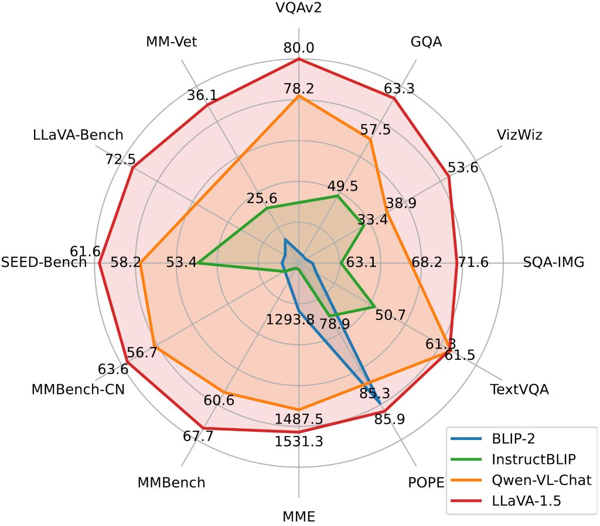

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



🦙 LLaVA 1.6 Mistral Description:
--------------------------------------------------------------------------------
The image is a circular radar chart with a central red diamond shape, which is the focal point of the chart. The chart is divided into eight segments, each representing a different category or metric. These categories are labeled as follows: MM-Vet, MM-Vet, MM-Vet, MM-Vet, MM-Vet, MM-Vet, MM-Vet, and MM-Vet. Each segment contains a numerical value ranging from 0 to 100, indicating some form of measurement or score for each category.

The central red diamond shape is connected to the segments by lines, suggesting a relationship or correlation between the central value and the values in each segment. The lines are color-coded, with different colors representing different segments.

In the bottom right corner of the image, there is a legend with four color-coded boxes, each labeled with a different category: BL


In [5]:
for image_path in image_files:
    print_section(f"Image: {image_path.name}")
    
    display_image(image_path)
    
    print_subsection("🦙 LLaVA 1.6 Mistral Description:")
    try:
        desc = describe_image(image_path)
        print(desc)
    except Exception as e:
        print(f"Error: {e}")


## Custom Prompts

Try asking specific questions about an image.



Custom Prompts - sample_image.jpg


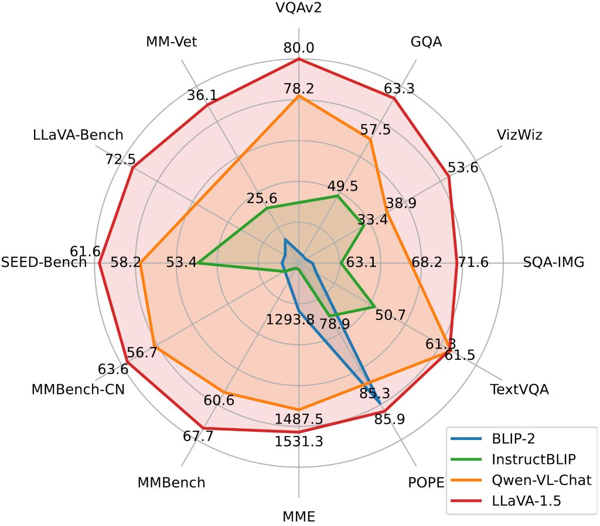

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Q: What objects can you see in this image?
--------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


A: The image appears to be a radar chart, which is a type of graph that displays multivariate data in the form of a two-dimensional chart of three or more quantitative variables represented on axes starting from the same point.

In this particular radar chart, there are several objects or categories represented along the axes:

1. MM-Vet
2. MM-Bench
3. LLaVA-Bench
4. SLED-Bench
5. MM-Bench-CN
6. MM-Bench-CN
7. MM-Bench-CN
8. MM-Bench-CN
9. MM-Bench-CN
10. MM-Bench-CN
11. MM-Bench-CN
12. MM-Bench-CN
13. MM-Bench-CN
14.

Q: What colors are prominent in this image?
--------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


A: The image is a colorful circular diagram with various shades of red, orange, yellow, green, blue, and pink. The colors are used to represent different categories or data points, such as different types of benchmarks or performance metrics. The specific colors and their meanings are not labeled in the image, so it's not possible to determine the exact significance of each color without additional context.

Q: What is the main subject of this image?
--------------------------------------------------------------------------------
A: The image appears to be a radar chart, which is a type of multivariate chart that displays values for multiple variables represented on axes starting from the same point. The chart is used to compare the performance of different models or systems across various metrics.

The axes of the chart are labeled with different metrics such as "MMM-Vet," "MMM-Bench," "LLaVA-Bench," "SLED-Bench," "SEED-Bench," "MMM-Bench-CN," "MMM-Bench-CN," "MMM-Bench-CN," "MMM-Benc

In [6]:
if image_files:
    test_image = image_files[0]
    
    custom_prompts = [
        "What objects can you see in this image?",
        "What colors are prominent in this image?",
        "What is the main subject of this image?"
    ]
    
    print_section(f"Custom Prompts - {test_image.name}")
    display_image(test_image)
    
    for prompt in custom_prompts:
        print_subsection(f"Q: {prompt}")
        answer = describe_image(test_image, prompt)
        print(f"A: {answer}")
